# Data Preprocessing

## Importing Data

In [1]:
import pandas as pd

In [91]:
data_fol = "data_reviews/"

In [92]:
x_test = pd.read_csv(data_fol+"x_test.csv")
x_train = pd.read_csv(data_fol+"x_train.csv")
y_train = pd.read_csv(data_fol+"y_train.csv")
# Mods
y_train.columns = ['positive']
x_train.at[:,'length'] = x_train['text'].apply(lambda x: len(x))

## Data Exploration

In [93]:
pd.set_option('display.max_colwidth', 150) 

In [94]:
x_train.describe(include='all')

,website_name,text,length
count,2400,2400,2400.000000
unique,3,2389,NaN
top,amazon,Excellent product for the price.,NaN
freq,800,2,NaN
mean,NaN,NaN,65.344167
std,NaN,NaN,43.132481
min,NaN,NaN,7.000000
25%,NaN,NaN,33.000000
50%,NaN,NaN,56.000000
75%,NaN,NaN,88.000000


### Initial Notes    

- We may consier each review to be unique (despite being one repeated intsance. P(review is repeated)=<<1)
- Reviews are around 70 chars.
- Reviews range from 7 o 336 chars.

In [95]:
import seaborn as sns
import matplotlib.pyplot as plt

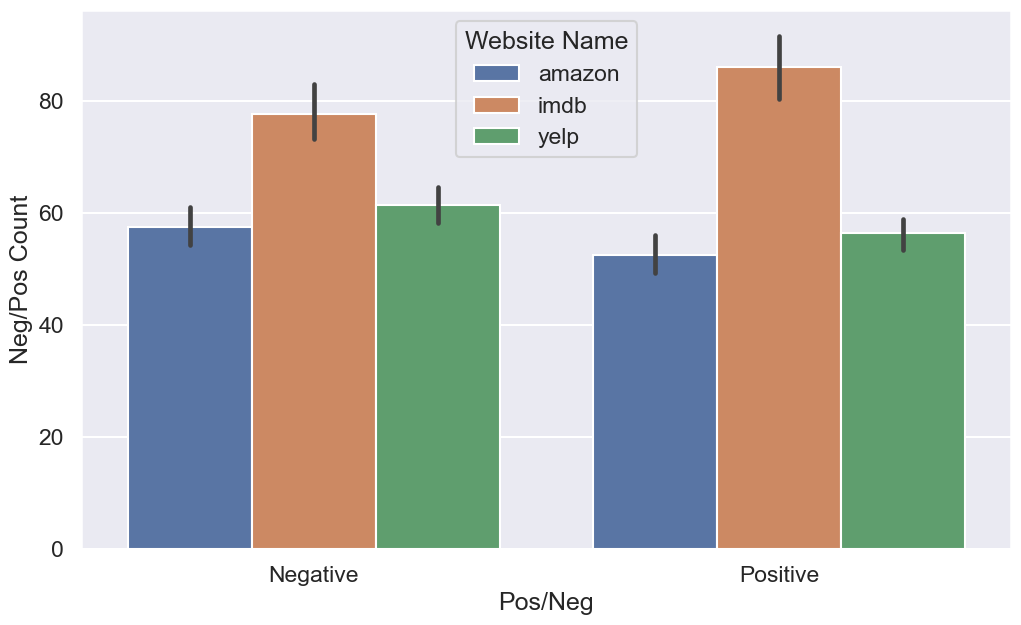

In [96]:
sns.set(context='talk')

fig, ax = plt.subplots(figsize=(12, 7))

sns.barplot(
    x=y_train['positive'], 
    y=x_train['length'],
    hue=x_train['website_name'], 
    ax=ax,
)

# Customizing the legend title
ax.legend(title='Website Name')

# Customizing the axis titles
ax.set_ylabel('Neg/Pos Count')
ax.set_xlabel('Pos/Neg')

# Changing the x-axis ticks
ax.set_xticks([0, 1])
ax.set_xticklabels(['Negative', 'Positive'])

plt.show()

### Notes on Website  

The distribution of negative and positive impressions across websites seems balanced. Probably want to stratify accross these when splitting the data.

## Data Cleaning

In [97]:
import spacy
from spacy.language import Language
import numpy as np
from spellchecker import SpellChecker
from spacy.attrs import LOWER, POS
from spacy.tokens import Doc
from sklearn.feature_extraction.text import CountVectorizer
import re
from scipy.sparse import csr_matrix

In [98]:
x_train.head(10)

,website_name,text,length
0,amazon,Oh and I forgot to also mention the weird color effect it has on your phone.,76
1,amazon,THAT one didn't work either.,28
2,amazon,Waste of 13 bucks.,18
3,amazon,"Product is useless, since it does not have enough charging current to charge the 2 cellphones I was planning to use it with.",124
4,amazon,None of the three sizes they sent with the headset would stay in my ears.,73
5,amazon,Worst customer service.,23
6,amazon,The Ngage is still lacking in earbuds.,38
7,amazon,It always cuts out and makes a beep beep beep sound then says signal failed.,76
8,amazon,the only VERY DISAPPOINTING thing was there was NO SPEAKERPHONE!!!!,67
9,amazon,Very disappointed in AccessoryOne.,34


In [99]:
spell = SpellChecker(distance=3)
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])
stop_words_to_keep = ["n't", "some", "no"]
for word in stop_words_to_keep:
    nlp.Defaults.stop_words.remove(word)

KeyError: "n't"

In [100]:


def NLP_review(review_text):
    # Remove punctuation except for ! and ?
    clean_text = re.sub(r"[^\w\s!?']", "", review_text)
    # Normalize letter repetition
    clean_text = re.sub(r"(\w)\1{2,}", r"\1\1", clean_text)
    # Take care of ellipsis 
    clean_text = re.sub(r'\.\.\.|…', ' <ELLIPSIS> ', clean_text)
    # Handle em dashes
    clean_text = re.sub(r'--', ' <EMDASH> ', clean_text)
    

    def process_word(w):
        if w.is_stop:
            return ""
        if w.pos_ != "PROPN":
            w = w.lower_
        else:
            w = w.text
        if spell.correction(w):
            w = spell.correction(w)
        return w
        
    clean_text = " ".join([process_word(token) for token in nlp(clean_text)])
    # Normalize spaces
    clean_text = re.sub(r"\s+", " ", clean_text)
    clean_text = clean_text.strip()
    # Separate n't 
    # clean_text = re.sub(r"n't", " n't", clean_text)
    
    return clean_text

In [101]:
NLP_review("Some didn't it gooooood BET some erors in John this setnence. Is SPEAKERPHONE it a good review? Maybe it's a bad onq! No one knows yet")

'some not good bet some errors John sentence speakerphone good review ? maybe bad on ! no knows'

In [102]:
x_train_clean = [NLP_review(rev) for rev in x_train.text.tolist()]
print(x_train_clean[:20])

['oh forgot mention weird color effect phone', 'not work', 'waste 13 bucks', 'product useless charging current charge 2 cellphones planning use', 'sizes sent headset stay ears', 'worst customer service', 'engage lacking barbuda', 'cuts makes beep beep beep sound says signal failed', 'disappointing thing no SPEAKERPHONE ! ! ! !', 'disappointed AccessoryOne', 'basically service bad', 'Bad Choice', 'thing disappoint infra red port idea', 'horrible switch 3 times', 'feels poorly constructed menus difficult navigate buttons recessed difficult push', 'not mistake', 'muddy low quality sound casing wire insert poorly super glued slid', 'advise fooled !', 'not hold charge', 'waste time !']


In [103]:
for x, y in zip(x_train.text[:15], x_train_clean[:15]):
    print(x, "||||", y)
    print("---")

Oh and I forgot to also mention the weird color effect it has on your phone. |||| oh forgot mention weird color effect phone
---
THAT one didn't work either. |||| not work
---
Waste of 13 bucks. |||| waste 13 bucks
---
Product is useless, since it does not have enough charging current to charge the 2 cellphones I was planning to use it with. |||| product useless charging current charge 2 cellphones planning use
---
None of the three sizes they sent with the headset would stay in my ears. |||| sizes sent headset stay ears
---
Worst customer service. |||| worst customer service
---
The Ngage is still lacking in earbuds. |||| engage lacking barbuda
---
It always cuts out and makes a beep beep beep sound then says signal failed. |||| cuts makes beep beep beep sound says signal failed
---
the only VERY DISAPPOINTING thing was there was NO SPEAKERPHONE!!!! |||| disappointing thing no SPEAKERPHONE ! ! ! !
---
Very disappointed in AccessoryOne. |||| disappointed AccessoryOne
---
Basically the 

## Vectorizing

In [104]:
review_vectorizer = CountVectorizer()
x_train_vec = review_vectorizer.fit_transform(x_train_clean)
print(x_train_vec[:30])

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 126 stored elements and shape (30, 4183)>
  Coords	Values
  (0, 2487)	1
  (0, 1500)	1
  (0, 2281)	1
  (0, 4070)	1
  (0, 722)	1
  (0, 1198)	1
  (0, 2661)	1
  (1, 2453)	1
  (1, 4131)	1
  (2, 4041)	1
  (2, 8)	1
  (2, 486)	1
  (3, 2819)	1
  (3, 3943)	1
  (3, 623)	1
  (3, 923)	1
  (3, 617)	1
  (3, 593)	1
  (3, 2696)	1
  (3, 3940)	1
  (4, 3328)	1
  (4, 3224)	1
  (4, 1712)	1
  (4, 3473)	1
  (4, 1179)	1
  :	:
  (22, 3693)	1
  (22, 1849)	1
  (22, 4058)	1
  (23, 1349)	1
  (23, 3815)	1
  (23, 3897)	1
  (23, 2348)	1
  (23, 2836)	1
  (24, 2819)	1
  (24, 1045)	1
  (24, 2501)	1
  (24, 2955)	1
  (24, 274)	1
  (25, 36)	1
  (25, 1124)	1
  (26, 64)	1
  (26, 1986)	1
  (27, 2661)	1
  (27, 2453)	1
  (27, 3504)	1
  (27, 2464)	1
  (27, 1755)	1
  (28, 1064)	1
  (29, 2955)	1
  (29, 1955)	1


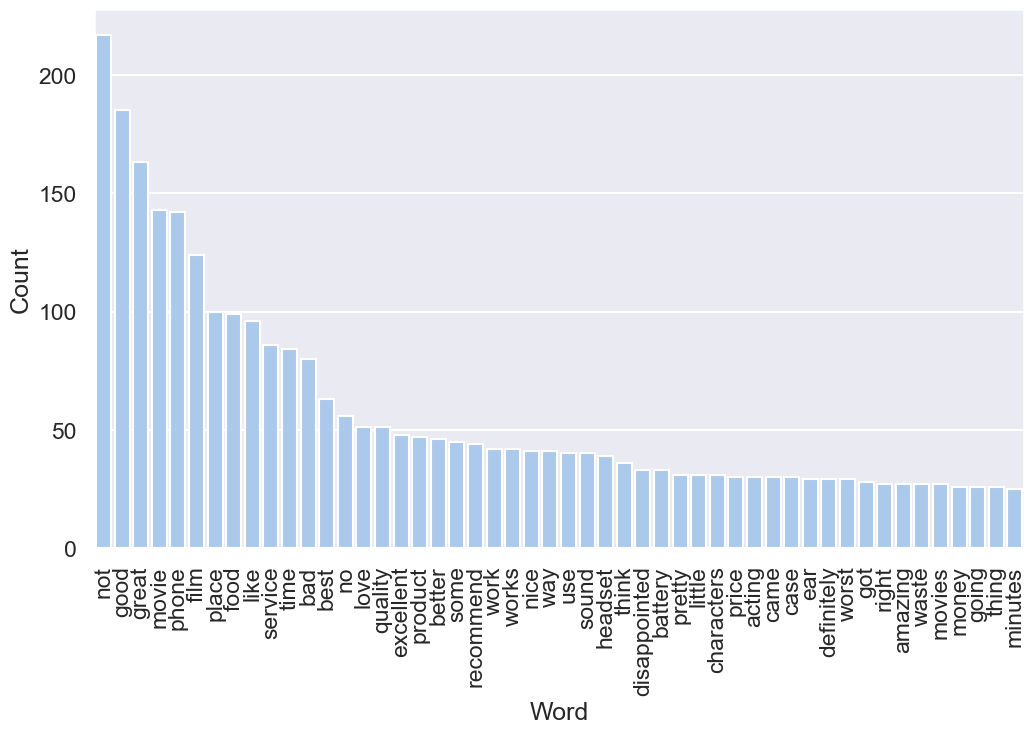

In [105]:
word_doc_occurrences = np.array(x_train_vec.sum(axis=0))[0]
word_freqs_idcs = np.argsort(word_doc_occurrences)[::-1]

sns.set(context='talk', palette="pastel")

fig, ax = plt.subplots(figsize=(12, 7))

sns.barplot(
    x=review_vectorizer.get_feature_names_out()[word_freqs_idcs][:50], 
    y=word_doc_occurrences[word_freqs_idcs][:50],
    ax=ax,
)

# Customizing the axis titles
ax.set_ylabel('Count')
ax.set_xlabel('Word')

# Changing the x-axis ticks
ax.tick_params(axis='x', rotation=90)
plt.show()

## Visualizing Bag Of Words Pos/Neg Separation

In [66]:
review_vectorizer.get_feature_names_out()

array(['010', '10', '100', ..., 'zero', 'zillion', 'zombie'], dtype=object)

In [80]:
[(review_vectorizer.get_feature_names_out())[np.array(x_train_vec[i].toarray()[0] > 0)] for i in range(x_train_vec.shape[0])]

[array(['color', 'effect', 'forgot', 'mention', 'oh', 'phone', 'weird'],
       dtype=object),
 array(['work'], dtype=object),
 array(['13', 'bucks', 'waste'], dtype=object),
 array(['cellphones', 'charge', 'charging', 'current', 'planning',
        'product', 'use', 'useless'], dtype=object),
 array(['ears', 'headset', 'sent', 'sizes', 'stay'], dtype=object),
 array(['customer', 'service', 'worst'], dtype=object),
 array(['barbuda', 'engage', 'lacking'], dtype=object),
 array(['beep', 'cuts', 'failed', 'makes', 'says', 'signal', 'sound'],
       dtype=object),
 array(['disappointing', 'no', 'speakerphone', 'thing'], dtype=object),
 array(['accessoryone', 'disappointed'], dtype=object),
 array(['bad', 'basically', 'service'], dtype=object),
 array(['bad', 'choice'], dtype=object),
 array(['disappoint', 'idea', 'infra', 'port', 'red', 'thing'],
       dtype=object),
 array(['horrible', 'switch', 'times'], dtype=object),
 array(['buttons', 'constructed', 'difficult', 'feels', 'menus',
  

In [106]:
full_corpus = np.array([
    " ".join(
        (review_vectorizer.get_feature_names_out())[np.array(x_train_vec[i].toarray()[0] > 0)]
         ) for i in range(x_train_vec.shape[0])
])

In [107]:
full_corpus

array(['color effect forgot mention oh phone weird', 'not work',
       '13 bucks waste', ..., 'ambience perfect',
       'char duck inside nice ordered outside pink rare tender',
       'better company good service'], dtype='<U216')

In [108]:
pos_corpus = review_vectorizer.transform(full_corpus[y_train.positive.to_numpy().astype(bool)])
neg_corpus = review_vectorizer.transform(full_corpus[y_train.positive.to_numpy() == 0])

In [53]:
# def get_corptop_50(corpus):
#     word_doc_occurrences = np.array(corpus.sum(axis=0))[0]
#     word_freqs_idcs = np.argsort(word_doc_occurrences)[::-1]

#     x=review_vectorizer.get_feature_names_out()[word_freqs_idcs][:50]
#     y=word_doc_occurrences[word_freqs_idcs][:50]
#     return x, y

# sns.set(context='talk', palette="pastel")

# fig, ax = plt.subplots(figsize=(12, 7))

# cp = get_corptop_50(pos_corpus)
# np = get_corptop_50(neg_corpus)
# sns.barplot(
#     x=cp[0], 
#     y=cp[1],
#     ax=ax1,
# )

# sns.barplot(
#     x=np[0], 
#     y=np[1],
#     ax=ax2,
# )

# # Customizing the axis titles
# ax1.set_ylabel('Count')
# ax1.set_xlabel('Word')
# ax2.set_ylabel('Count')
# ax2.set_xlabel('Word')

# # Changing the x-axis ticks
# ax1.tick_params(axis='x', rotation=90)
# ax2.tick_params(axis='x', rotation=90)
# plt.show()

In [109]:
def get_corptop_50(corp):
    """
    Calculates the frequencies of the top 50 words in a corpus.

    Args:
      corpus: The corpus represented as a sparse matrix.

    Returns:
      A tuple containing:
        - x: An array of the top 50 words.
        - y: An array of the corresponding frequencies of the top 50 words.
    """
    word_doc_occ = corp.sum(axis=0).A[0]
    word_freqs_ids = np.argsort(word_doc_occ)[::-1]

    x = review_vectorizer.get_feature_names_out()[word_freqs_ids][:50]
    y = word_doc_occ[word_freqs_ids][:50]
    return x, y

cp = get_corptop_50(pos_corpus)
cn = get_corptop_50(neg_corpus)

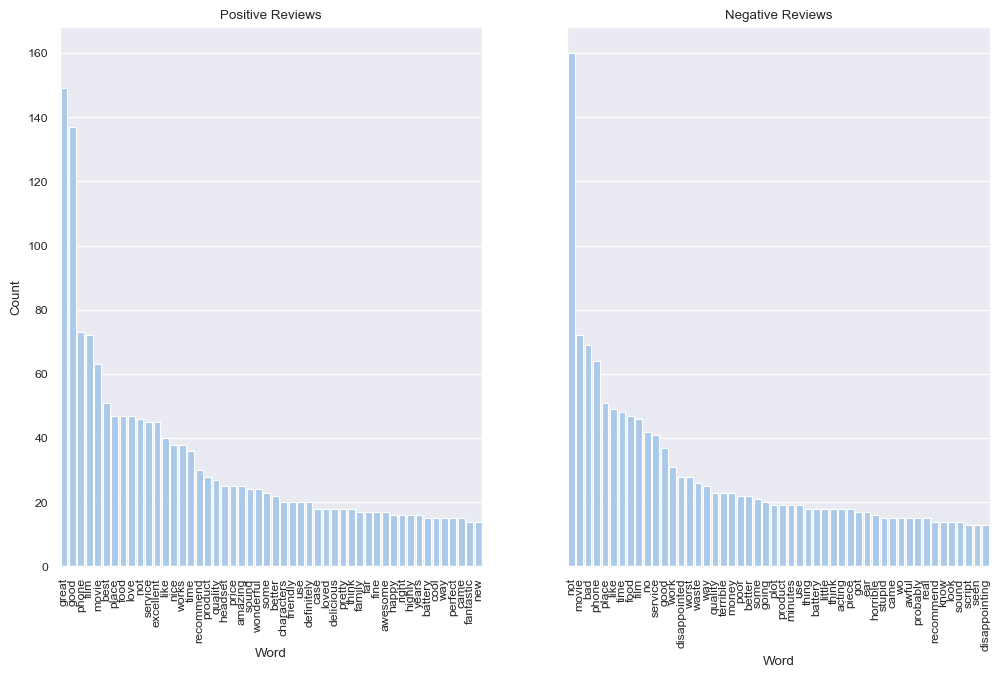

In [110]:
sns.set(context='paper', palette="pastel")

fig, ax = plt.subplots(1, 2, figsize=(12, 7), sharey=True)

sns.barplot(
    x=cp[0],
    y=cp[1],
    ax=ax[0],
)

sns.barplot(
    x=cn[0],
    y=cn[1],
    ax=ax[1],
)

# Customizing the axis titles
ax[0].set_ylabel('Count')
ax[0].set_xlabel('Word')
ax[1].set_xlabel('Word')

# Changing the x-axis ticks
ax[0].tick_params(axis='x', rotation=90)
ax[1].tick_params(axis='x', rotation=90)

ax[0].set_title("Positive Reviews")
ax[1].set_title("Negative Reviews")

plt.show()

In [51]:
x_train

,website_name,text,length
0,amazon,Oh and I forgot to also mention the weird color effect it has on your phone.,76
1,amazon,THAT one didn't work either.,28
2,amazon,Waste of 13 bucks.,18
3,amazon,"Product is useless, since it does not have enough charging current to charge the 2 cellphones I was planning to use it with.",124
4,amazon,None of the three sizes they sent with the headset would stay in my ears.,73
...,...,...,...
2395,yelp,The sweet potato fries were very good and seasoned well.,56
2396,yelp,I could eat their bruschetta all day it is devine.,50
2397,yelp,Ambience is perfect.,20
2398,yelp,We ordered the duck rare and it was pink and tender on the inside with a nice char on the outside.,98


# Building Model

In [61]:
full_corpus

array(['color effect forgot mention oh phone weird', 'not work',
       '13 bucks waste', ..., 'ambience perfect',
       'char duck inside nice ordered outside pink rare tender',
       'better company good service'], dtype='<U216')

In [62]:
x_train_vec

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 12658 stored elements and shape (2400, 4183)>

I will start my analysis using the full set of words exctracted to get an initial guage of the accuracy they permit. I will then iterate on the number of words I use as I see fit.

In [111]:
# Making Subset of x_train with top 200 words
dense_x_train = x_train_vec[:,word_freqs_idcs[:200]].toarray()
dense_x_train

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]], dtype=int64)

In [192]:
import sklearn.linear_model
import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split
import tqdm
import sklearn.pipeline
import numpy as np
from scipy.stats import uniform

In [114]:
x_dense_train, x_dense_test, y_dense_train, y_dense_test = train_test_split(
    dense_x_train, 
    y_train.positive.tolist(), 
    test_size=0.2, 
    random_state=42,
    stratify=y_train.positive.tolist()
)

In [136]:
np.logspace(-6, 6, num=10)

array([1.00000000e-06, 2.15443469e-05, 4.64158883e-04, 1.00000000e-02,
       2.15443469e-01, 4.64158883e+00, 1.00000000e+02, 2.15443469e+03,
       4.64158883e+04, 1.00000000e+06])

In [205]:
# Create a pipeline
pipeline = sklearn.pipeline.Pipeline([
    # ('scaler', StandardScaler()),  # Standardize features
    ('logreg', sklearn.linear_model.LogisticRegression())  # Linear Regression model
])

# Define the parameter grid to search
param_grid = {
    'logreg__penalty': ['l1', 'l2', 'elasticnet'],
    'logreg__C': np.logspace(1, 3, num=5),
    'logreg__solver': ['lbfgs', 'liblinear', 'saga'],
    'logreg__max_iter': [100, 200, 500],
    'logreg__class_weight': [None, 'balanced'],
    'logreg__l1_ratio': np.linspace(0,1,4)
}

# Create the GridSearchCV object
grid_search = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=5, 
    scoring='roc_auc',
    return_train_score=True,
    verbose=0
)  # 5-fold cross-validation

# Fit the grid search to the training data
grid_search.fit(x_dense_train, y_dense_train)
# Fit the grid search to the training data (using tqdm correctly)
# with tqdm(total=grid_search.n_splits_) as pbar:
#     grid_search.fit(x_dense_train, y_dense_train, model__callback=lambda *args: pbar.update())

# Print the best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_

C:\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\Python\Python312\Lib\site-packages\sklearn\linear_model\_logis

Best Parameters: {'logreg__C': 10.0, 'logreg__class_weight': None, 'logreg__l1_ratio': 0.0, 'logreg__max_iter': 100, 'logreg__penalty': 'l2', 'logreg__solver': 'saga'}
Best Score: 0.8355767144097221


C:\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [199]:
np.linspace(0,1,11)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [209]:
topN_models = pd.DataFrame(grid_search.cv_results_).sort_values(by="mean_test_score", ascending=False)
topN_models = topN_models[topN_models.mean_test_score > 0.5].reset_index(drop=True)
print(topN_models.columns)
topN_models = topN_models[["params", "mean_test_score", "std_test_score", "mean_train_score", "std_train_score", "mean_fit_time"]]
topN_models = pd.concat(
    [
        topN_models, 
        pd.DataFrame([pd.Series(topN_models['params'][i]) for i in range(topN_models.shape[0])])
    ], axis = 1
)

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_logreg__C', 'param_logreg__class_weight',
       'param_logreg__l1_ratio', 'param_logreg__max_iter',
       'param_logreg__penalty', 'param_logreg__solver', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'split0_train_score',
       'split1_train_score', 'split2_train_score', 'split3_train_score',
       'split4_train_score', 'mean_train_score', 'std_train_score'],
      dtype='object')


In [210]:
topN_models

,params,mean_test_score,std_test_score,mean_train_score,std_train_score,mean_fit_time,logreg__C,logreg__class_weight,logreg__l1_ratio,logreg__max_iter,logreg__penalty,logreg__solver
0,"{'logreg__C': 10.0, 'logreg__class_weight': None, 'logreg__l1_ratio': 0.0, 'logreg__max_iter': 100, 'logreg__penalty': 'l2', 'logreg__solver': 'sa...",0.835577,0.018133,0.908466,0.003626,0.194502,10.0,None,0.000000,100,l2,saga
1,"{'logreg__C': 10.0, 'logreg__class_weight': None, 'logreg__l1_ratio': 0.3333333333333333, 'logreg__max_iter': 100, 'logreg__penalty': 'l2', 'logre...",0.835550,0.018156,0.908467,0.003625,0.200095,10.0,None,0.333333,100,l2,saga
2,"{'logreg__C': 10.0, 'logreg__class_weight': 'balanced', 'logreg__l1_ratio': 0.3333333333333333, 'logreg__max_iter': 100, 'logreg__penalty': 'l2', ...",0.835544,0.018174,0.908466,0.003627,0.207131,10.0,balanced,0.333333,100,l2,saga
3,"{'logreg__C': 10.0, 'logreg__class_weight': 'balanced', 'logreg__l1_ratio': 0.6666666666666666, 'logreg__max_iter': 100, 'logreg__penalty': 'l2', ...",0.835533,0.018127,0.908470,0.003627,0.201948,10.0,balanced,0.666667,100,l2,saga
4,"{'logreg__C': 10.0, 'logreg__class_weight': 'balanced', 'logreg__l1_ratio': 0.0, 'logreg__max_iter': 100, 'logreg__penalty': 'elasticnet', 'logreg...",0.835533,0.018147,0.908466,0.003631,0.202031,10.0,balanced,0.000000,100,elasticnet,saga
...,...,...,...,...,...,...,...,...,...,...,...,...
715,"{'logreg__C': 1000.0, 'logreg__class_weight': None, 'logreg__l1_ratio': 0.6666666666666666, 'logreg__max_iter': 200, 'logreg__penalty': 'l1', 'log...",0.823310,0.016860,0.910064,0.004006,0.002800,1000.0,None,0.666667,200,l1,liblinear
716,"{'logreg__C': 1000.0, 'logreg__class_weight': 'balanced', 'logreg__l1_ratio': 0.3333333333333333, 'logreg__max_iter': 200, 'logreg__penalty': 'l1'...",0.823310,0.016823,0.910063,0.004005,0.003000,1000.0,balanced,0.333333,200,l1,liblinear
717,"{'logreg__C': 1000.0, 'logreg__class_weight': 'balanced', 'logreg__l1_ratio': 0.6666666666666666, 'logreg__max_iter': 200, 'logreg__penalty': 'l1'...",0.823310,0.016823,0.910064,0.004005,0.003399,1000.0,balanced,0.666667,200,l1,liblinear
718,"{'logreg__C': 1000.0, 'logreg__class_weight': None, 'logreg__l1_ratio': 0.6666666666666666, 'logreg__max_iter': 500, 'logreg__penalty': 'l1', 'log...",0.823299,0.016851,0.910064,0.004007,0.003000,1000.0,None,0.666667,500,l1,liblinear


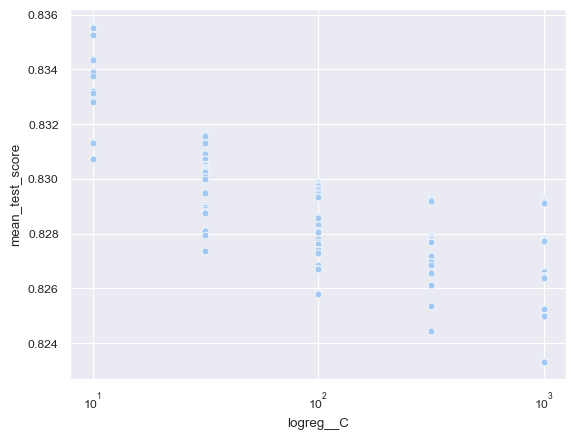

In [211]:
sns.scatterplot(data = topN_models, x = "logreg__C", y = "mean_test_score")
plt.xscale('log')

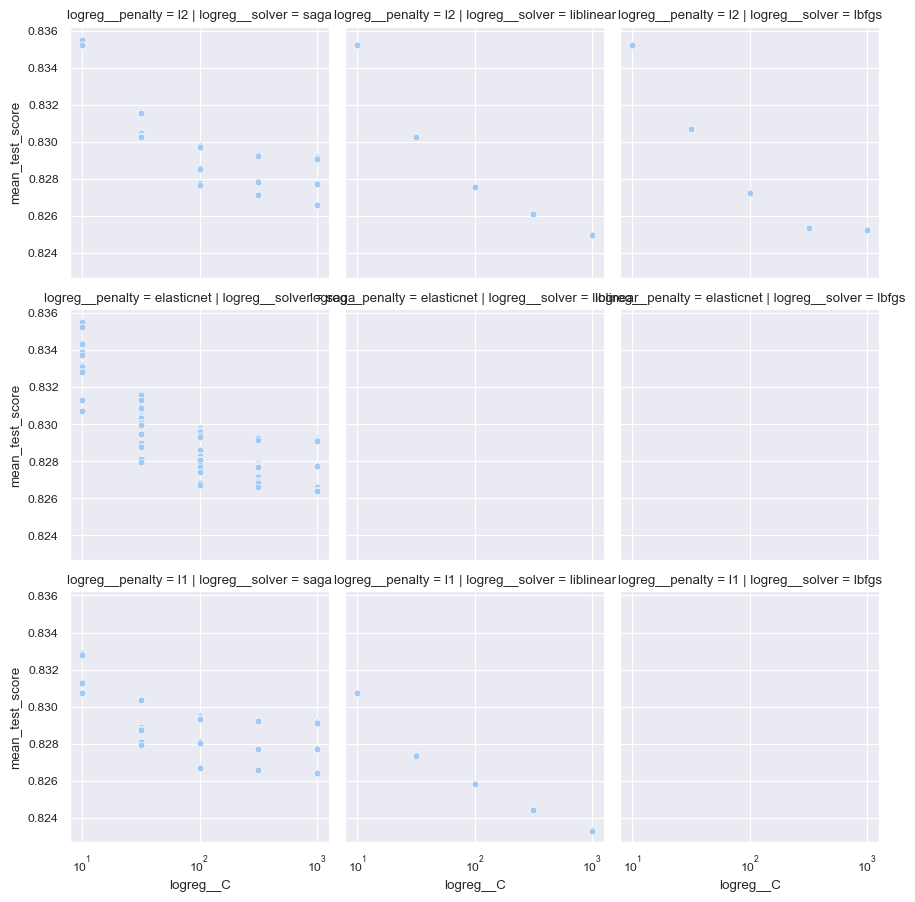

In [212]:
g = sns.FacetGrid(topN_models, col="logreg__solver",  row="logreg__penalty")
g.map(sns.scatterplot, "logreg__C", "mean_test_score")
plt.xscale('log')

In [204]:
topN_models[topN_models.mean_test_score > 0.5][:30]

,params,mean_test_score,std_test_score,mean_train_score,std_train_score,mean_fit_time,logreg__C,logreg__class_weight,logreg__max_iter,logreg__penalty,logreg__solver
0,"{'logreg__C': 100, 'logreg__class_weight': None, 'logreg__max_iter': 100, 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear'}",0.825814,0.017341,0.910102,0.004037,0.002199,100.0,None,100,l1,liblinear
1,"{'logreg__C': 100, 'logreg__class_weight': 'balanced', 'logreg__max_iter': 100, 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear'}",0.825814,0.017341,0.910101,0.004038,0.002598,100.0,balanced,100,l1,liblinear
2,"{'logreg__C': 100, 'logreg__class_weight': None, 'logreg__max_iter': 500, 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear'}",0.825814,0.017341,0.910101,0.004038,0.002502,100.0,None,500,l1,liblinear
3,"{'logreg__C': 100, 'logreg__class_weight': 'balanced', 'logreg__max_iter': 200, 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear'}",0.825825,0.017321,0.910100,0.004039,0.002999,100.0,balanced,200,l1,liblinear
4,"{'logreg__C': 100, 'logreg__class_weight': None, 'logreg__max_iter': 200, 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear'}",0.825814,0.017341,0.910100,0.004037,0.002600,100.0,None,200,l1,liblinear
5,"{'logreg__C': 100, 'logreg__class_weight': 'balanced', 'logreg__max_iter': 500, 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear'}",0.825803,0.017336,0.910100,0.004038,0.003000,100.0,balanced,500,l1,liblinear
6,"{'logreg__C': 100, 'logreg__class_weight': 'balanced', 'logreg__max_iter': 100, 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs'}",0.827276,0.017991,0.910000,0.003877,0.014807,100.0,balanced,100,l2,lbfgs
7,"{'logreg__C': 100, 'logreg__class_weight': None, 'logreg__max_iter': 500, 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs'}",0.827276,0.017991,0.910000,0.003877,0.014105,100.0,None,500,l2,lbfgs
8,"{'logreg__C': 100, 'logreg__class_weight': 'balanced', 'logreg__max_iter': 500, 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs'}",0.827276,0.017991,0.910000,0.003877,0.014703,100.0,balanced,500,l2,lbfgs
9,"{'logreg__C': 100, 'logreg__class_weight': None, 'logreg__max_iter': 100, 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs'}",0.827276,0.017991,0.910000,0.003877,0.014101,100.0,None,100,l2,lbfgs


Best Parameters: {'logreg__C': 10.0, 'logreg__class_weight': None, 'logreg__l1_ratio': 0.0, 'logreg__max_iter': 100, 'logreg__penalty': 'l2', 'logreg__solver': 'saga'}  
Best Score: 0.8355767144097221

In [214]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    auc,
)

Threshold: 0.0
  Accuracy: 0.5000
  Precision: 0.5000
  True Positive Rate (Recall): 1.0000
  True Negative Rate (Specificity): 0.0000
  F1 Score: 0.6667
--------------------
Threshold: 0.1
  Accuracy: 0.6333
  Precision: 0.5784
  True Positive Rate (Recall): 0.9833
  True Negative Rate (Specificity): 0.2833
  F1 Score: 0.7284
--------------------
Threshold: 0.2
  Accuracy: 0.6750
  Precision: 0.6141
  True Positive Rate (Recall): 0.9417
  True Negative Rate (Specificity): 0.4083
  F1 Score: 0.7434
--------------------
Threshold: 0.3
  Accuracy: 0.7042
  Precision: 0.6424
  True Positive Rate (Recall): 0.9208
  True Negative Rate (Specificity): 0.4875
  F1 Score: 0.7568
--------------------
Threshold: 0.4
  Accuracy: 0.7229
  Precision: 0.6743
  True Positive Rate (Recall): 0.8625
  True Negative Rate (Specificity): 0.5833
  F1 Score: 0.7569
--------------------
Threshold: 0.5
  Accuracy: 0.7562
  Precision: 0.7808
  True Positive Rate (Recall): 0.7125
  True Negative Rate (Specificity

C:\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


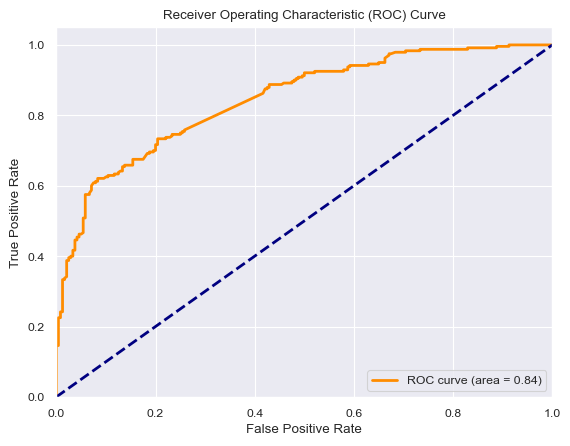

In [216]:
# Assuming you have already trained your model and have x_dense_test and y_dense_test

# Get predicted probabilities
y_prob = best_model.predict_proba(x_dense_test)[:, 1]

# Define thresholds to test
thresholds = np.arange(0, 1.1, 0.1)  # Thresholds from 0 to 1 in steps of 0.1

# Calculate and print metrics for each threshold
for threshold in thresholds:
    y_pred = (y_prob >= threshold).astype(int)  # Apply threshold

    # Calculate metrics (same as before)
    accuracy = accuracy_score(y_dense_test, y_pred)
    precision = precision_score(y_dense_test, y_pred)
    recall = recall_score(y_dense_test, y_pred)
    f1 = f1_score(y_dense_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_dense_test, y_pred).ravel()
    true_negative_rate = tn / (tn + fp)

    print(f"Threshold: {threshold:.1f}")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  True Positive Rate (Recall): {recall:.4f}")
    print(f"  True Negative Rate (Specificity): {true_negative_rate:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    print("-" * 20)

# Calculate and plot ROC curve
fpr, tpr, _ = roc_curve(y_dense_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

In [ ]:
import pickle

# Assuming you have your trained 'best_model' and 'review_vectorizer'

# Save the logistic regression model
with open("logistic_regression_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

# Save the review vectorizer
with open("review_vectorizer.pkl", "wb") as f:
    pickle.dump(review_vectorizer, f)

In [ ]:
# Pickling 
# Text transformer
review_vectorizer
# Model
best_model